In [2]:
try:
    done
except:
    done = True
    !mkdir lenses
    !tar -xf /kaggle/input/ml4sci/lenses.tgz
    !pip install -q e2cnn

**Specific Test IV. Exploring Equivariant Neural Networks**

**Task:** Use an Equivariant Neural Network of your choice to build a robust and efficient model for binary classification or unsupervised anomaly detection on the provided dataset. In the case of unsupervised anomaly detection, train your model to learn the distribution of the provided strong lensing images with no substructure. Please implement your approach in PyTorch or Keras and discuss your strategy.


**Dataset Description:** A set of simulated strong gravitational lensing images with and without substructure. 

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)


In [3]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from e2cnn import gspaces
from e2cnn import nn as e2nn
from itertools import cycle
from PIL import Image
from skimage import io, transform
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from torch import optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms, utils
from torchvision.transforms import (Compose, Pad, RandomRotation, Resize,
                                    ToTensor)

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Data Preparation

In [4]:
def get_train_valid_loader(
    data_dir,
    batch_size,
    random_seed,
    valid_size=0.1,
    shuffle=True,
):

    valid_transform = transforms.Compose(
        [
            transforms.RandomCrop(128),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )

    train_transform = transforms.Compose(
        [
            transforms.RandomRotation(30),
            transforms.RandomCrop(128),
            transforms.Resize(256),
            transforms.RandomRotation(180),
            transforms.ColorJitter(brightness=(0.8, 1.2)),
            transforms.Resize(128),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir,
        transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir,
        transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=2,
        pin_memory=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=2,
        pin_memory=True,
    )

    return (train_loader, valid_loader)

In [5]:
lr = 0.001
epochs = 10
gamma = 0.1
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lense_train, lense_test = get_train_valid_loader('lenses', batch_size, 40, 0.1)

# Model

In [6]:
from typing import Tuple

import torch
import torch.nn.functional as F

import math

import e2cnn.nn as enn
from e2cnn.nn import init
from e2cnn import gspaces


__all__ = [
    "wrn16_8_stl_d8d4d1",
    "wrn16_8_stl_d8d4d4",
    "wrn16_8_stl_d1d1d1",
    "wrn28_10_d8d4d1",
    "wrn28_7_d8d4d1",
    "wrn28_10_c8c4c1",
    "wrn28_10_d1d1d1",
]

def conv7x7(in_type: enn.FieldType, out_type: enn.FieldType, stride=1, padding=3,
            dilation=1, bias=False):
    """7x7 convolution with padding"""
    return enn.R2Conv(in_type, out_type, 7,
                      stride=stride,
                      padding=padding,
                      dilation=dilation,
                      bias=bias,
                      sigma=None,
                      frequencies_cutoff=lambda r: 3*r,
                      )


def conv5x5(in_type: enn.FieldType, out_type: enn.FieldType, stride=1, padding=2,
            dilation=1, bias=False):
    """5x5 convolution with padding"""
    return enn.R2Conv(in_type, out_type, 5,
                      stride=stride,
                      padding=padding, 
                      dilation=dilation,
                      bias=bias,
                      sigma=None,
                      frequencies_cutoff=lambda r: 3*r,
                      )


def conv3x3(in_type: enn.FieldType, out_type: enn.FieldType, stride=1, padding=1,
            dilation=1, bias=False):
    """3x3 convolution with padding"""
    return enn.R2Conv(in_type, out_type, 3,
                      stride=stride,
                      padding=padding,
                      dilation=dilation,
                      bias=bias,
                      sigma=None,
                      frequencies_cutoff=lambda r: 3*r,
                      )


def conv1x1(in_type: enn.FieldType, out_type: enn.FieldType, stride=1, padding=0,
            dilation=1, bias=False):
    """1x1 convolution with padding"""
    return enn.R2Conv(in_type, out_type, 1,
                      stride=stride,
                      padding=padding,
                      dilation=dilation,
                      bias=bias,
                      sigma=None,
                      frequencies_cutoff=lambda r: 3*r,
                      )


def regular_feature_type(gspace: gspaces.GSpace, planes: int, fixparams: bool = True):
    """ build a regular feature map with the specified number of channels"""
    assert gspace.fibergroup.order() > 0
    
    N = gspace.fibergroup.order()
    
    if fixparams:
        planes *= math.sqrt(N)
    
    planes = planes / N
    planes = int(planes)
    
    return enn.FieldType(gspace, [gspace.regular_repr] * planes)


def trivial_feature_type(gspace: gspaces.GSpace, planes: int, fixparams: bool = True):
    """ build a trivial feature map with the specified number of channels"""
    
    if fixparams:
        planes *= math.sqrt(gspace.fibergroup.order())
        
    planes = int(planes)
    return enn.FieldType(gspace, [gspace.trivial_repr] * planes)


FIELD_TYPE = {
    "trivial": trivial_feature_type,
    "regular": regular_feature_type,
}


class WideBasic(enn.EquivariantModule):
    
    def __init__(self,
                 in_type: enn.FieldType,
                 inner_type: enn.FieldType,
                 dropout_rate: float,
                 stride: int = 1,
                 out_type: enn.FieldType = None,
                 ):
        super(WideBasic, self).__init__()
        
        if out_type is None:
            out_type = in_type
        
        self.in_type = in_type
        inner_type = inner_type
        self.out_type = out_type
        
        if isinstance(in_type.gspace, gspaces.FlipRot2dOnR2):
            rotations = in_type.gspace.fibergroup.rotation_order
        elif isinstance(in_type.gspace, gspaces.Rot2dOnR2):
            rotations = in_type.gspace.fibergroup.order()
        else:
            rotations = 0
        
        if rotations in [0, 2, 4]:
            conv = conv3x3
        else:
            conv = conv5x5
        
        self.bn1 = enn.InnerBatchNorm(self.in_type)
        self.relu1 = enn.ReLU(self.in_type, inplace=True)
        self.conv1 = conv(self.in_type, inner_type)
        
        self.bn2 = enn.InnerBatchNorm(inner_type)
        self.relu2 = enn.ReLU(inner_type, inplace=True)
        
        self.dropout = enn.PointwiseDropout(inner_type, p=dropout_rate)
        
        self.conv2 = conv(inner_type, self.out_type, stride=stride)
        
        self.shortcut = None
        if stride != 1 or self.in_type != self.out_type:
            self.shortcut = conv1x1(self.in_type, self.out_type, stride=stride, bias=False)
    
    def forward(self, x):
        x_n = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(x_n)))
        out = self.dropout(out)
        out = self.conv2(out)
        
        if self.shortcut is not None:
            out += self.shortcut(x_n)
        else:
            out += x

        return out
    
    def evaluate_output_shape(self, input_shape: Tuple):
        assert len(input_shape) == 4
        assert input_shape[1] == self.in_type.size
        if self.shortcut is not None:
            return self.shortcut.evaluate_output_shape(input_shape)
        else:
            return input_shape


class Wide_ResNet(torch.nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes=100,
                 N: int = 8,
                 r: int = 1,
                 f: bool = True,
                 deltaorth: bool = False,
                 fixparams: bool = True,
                 initial_stride: int = 1,
                 ):

        super(Wide_ResNet, self).__init__()
        
        assert ((depth - 4) % 6 == 0), 'Wide-resnet depth should be 6n+4'
        n = int((depth - 4) / 6)
        k = widen_factor
        
        print(f'| Wide-Resnet {depth}x{k}')
        
        nStages = [16, 16 * k, 32 * k, 64 * k]
        
        self._fixparams = fixparams
        
        self._layer = 0
        
        # number of discrete rotations to be equivariant to
        self._N = N
        
        # if the model is [F]lip equivariant
        self._f = f
        if self._f:
            if N != 1:
                self.gspace = gspaces.FlipRot2dOnR2(N)
            else:
                self.gspace = gspaces.Flip2dOnR2()
        else:
            if N != 1:
                self.gspace = gspaces.Rot2dOnR2(N)
            else:
                self.gspace = gspaces.TrivialOnR2()

        assert r in [0, 1, 2, 3]
        self._r = r
        
        # the input has 3 color channels (RGB).
        # Color channels are trivial fields and don't transform when the input is rotated or flipped
        r1 = enn.FieldType(self.gspace, [self.gspace.trivial_repr])
        
        # input field type of the model
        self.in_type = r1
        
        # in the first layer we always scale up the output channels to allow for enough independent filters
        r2 = FIELD_TYPE["regular"](self.gspace, nStages[0], fixparams=True)
        
        # dummy attribute keeping track of the output field type of the last submodule built, i.e. the input field type of
        # the next submodule to build
        self._in_type = r2
        
        self.conv1 = conv5x5(r1, r2)
        self.layer1 = self._wide_layer(WideBasic, nStages[1], n, dropout_rate, stride=initial_stride)
        if self._r >= 2:
            N_new = N//2
            id = (0, N_new) if self._f else N_new
            self.restrict1 = self._restrict_layer(id)
        else:
            self.restrict1 = lambda x: x
        
        self.layer2 = self._wide_layer(WideBasic, nStages[2], n, dropout_rate, stride=2)
        if self._r == 3:
            id = (0, 1) if self._f else 1
            self.restrict2 = self._restrict_layer(id)
        elif self._r == 1:
            N_new = N // 2
            id = (0, N_new) if self._f else N_new
            self.restrict2 = self._restrict_layer(id)
        else:
            self.restrict2 = lambda x: x
        
        # last layer maps to a trivial (invariant) feature map
        self.layer3 = self._wide_layer(WideBasic, nStages[3], n, dropout_rate, stride=2, totrivial=True)
        
        self.bn = enn.InnerBatchNorm(self.layer3.out_type, momentum=0.9)
        self.relu = enn.ReLU(self.bn.out_type, inplace=True)
        self.linear = torch.nn.Linear(self.bn.out_type.size, num_classes)
        
        for name, module in self.named_modules():
            if isinstance(module, enn.R2Conv):
                if deltaorth:
                    init.deltaorthonormal_init(module.weights, module.basisexpansion)
            elif isinstance(module, torch.nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()
            elif isinstance(module, torch.nn.Linear):
                module.bias.data.zero_()
        
        print("MODEL TOPOLOGY:")
        for i, (name, mod) in enumerate(self.named_modules()):
            print(f"\t{i} - {name}")
    
    def _restrict_layer(self, subgroup_id) -> enn.SequentialModule:
        layers = list()
        layers.append(enn.RestrictionModule(self._in_type, subgroup_id))
        layers.append(enn.DisentangleModule(layers[-1].out_type))
        self._in_type = layers[-1].out_type
        self.gspace = self._in_type.gspace
        
        restrict_layer = enn.SequentialModule(*layers)
        return restrict_layer
    
    def _wide_layer(self, block, planes: int, num_blocks: int, dropout_rate: float, stride: int,
                    totrivial: bool = False
                    ) -> enn.SequentialModule:
    
        self._layer += 1
        print("start building", self._layer)
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        main_type = FIELD_TYPE["regular"](self.gspace, planes, fixparams=self._fixparams)
        inner_type = FIELD_TYPE["regular"](self.gspace, planes, fixparams=self._fixparams)
        
        if totrivial:
            out_type = FIELD_TYPE["trivial"](self.gspace, planes, fixparams=self._fixparams)
        else:
            out_type = FIELD_TYPE["regular"](self.gspace, planes, fixparams=self._fixparams)
        
        for b, stride in enumerate(strides):
            if b == num_blocks - 1:
                out_f = out_type
            else:
                out_f = main_type
            layers.append(block(self._in_type, inner_type, dropout_rate, stride, out_type=out_f))
            self._in_type = out_f
            
        print("layer", self._layer, "built")
        return enn.SequentialModule(*layers)
    
    def features(self, x):
        
        x = enn.GeometricTensor(x, self.in_type)
        
        out = self.conv1(x)
        
        x1 = self.layer1(out)
        
        x2 = self.layer2(self.restrict1(x1))
        
        x3 = self.layer3(self.restrict2(x2))
        
        return x1, x2, x3
    
    def forward(self, x):

        # wrap the input tensor in a GeometricTensor
        x = enn.GeometricTensor(x, self.in_type)
        
        out = self.conv1(x)
        out = self.layer1(out)
        
        out = self.layer2(self.restrict1(out))
        
        out = self.layer3(self.restrict2(out))
        
        out = self.bn(out)
        out = self.relu(out)
        
        # extract the tensor from the GeometricTensor to use the common Pytorch operations
        out = out.tensor
        
        b, c, w, h = out.shape
        out = F.avg_pool2d(out, (w, h))
        
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [7]:
model = Wide_ResNet(10, 4, 0.3, initial_stride=1, N=8, f=True, r=0, num_classes=2).to(device)

| Wide-Resnet 10x4

start building 1

layer 1 built

start building 2

layer 2 built

start building 3

layer 3 built

MODEL TOPOLOGY:

	0 - 

	1 - conv1

	2 - conv1._basisexpansion

	3 - conv1._basisexpansion.block_expansion_('irrep_0,0', 'regular')

	4 - layer1

	5 - layer1.0

	6 - layer1.0.bn1

	7 - layer1.0.bn1.batch_norm_[16]

	8 - layer1.0.relu1

	9 - layer1.0.conv1

	10 - layer1.0.conv1._basisexpansion

	11 - layer1.0.conv1._basisexpansion.block_expansion_('regular', 'regular')

	12 - layer1.0.bn2

	13 - layer1.0.bn2.batch_norm_[16]

	14 - layer1.0.relu2

	15 - layer1.0.dropout

	16 - layer1.0.conv2

	17 - layer1.0.conv2._basisexpansion

	18 - layer1.0.shortcut

	19 - layer1.0.shortcut._basisexpansion

	20 - layer1.0.shortcut._basisexpansion.block_expansion_('regular', 'regular')

	21 - layer2

	22 - layer2.0

	23 - layer2.0.bn1

	24 - layer2.0.bn1.batch_norm_[16]

	25 - layer2.0.relu1

	26 - layer2.0.conv1

	27 - layer2.0.conv1._basisexpansion

	28 - layer2.0.bn2

	29 - layer2.

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=gamma)

# Training

In [9]:
all_train_loss = []
all_test_loss = []
all_train_accuracy = []
all_test_accuracy = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    correct, total = 0,0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(lense_train):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)
        tr_loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).sum()
        correct += acc.item()
        total+= len(label)
        
        epoch_loss += loss / len(lense_train)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))
    all_train_accuracy.append(correct/total*100)
    epoch_accuracy = (correct/total)*100
    correct, total = 0,0

    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm(lense_test):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())
            acc = (val_output.argmax(dim=1) == label).sum()
            correct += acc.item()
            total += len(label)
            
            epoch_val_loss += val_loss / len(lense_test)
        all_test_loss.append(np.asarray(test_loss_epoch))
        all_test_accuracy.append(correct/total*100)
    epoch_val_accuracy = (correct/total)*100
    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(model)    
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}% - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}%"
    )
torch.save(best_model.state_dict(), 'equi_resnet.pth')
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████| 563/563 [18:42<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 1 - loss : 0.6351 - acc: 62.7778% - val_loss : 0.5454 - val_acc: 77.9000%


100%|██████████| 563/563 [18:38<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 2 - loss : 0.3757 - acc: 84.3333% - val_loss : 0.3247 - val_acc: 87.1000%


100%|██████████| 563/563 [18:38<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch : 3 - loss : 0.1737 - acc: 93.9333% - val_loss : 0.1215 - val_acc: 95.8000%


100%|██████████| 563/563 [18:38<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Epoch : 4 - loss : 0.0751 - acc: 97.7556% - val_loss : 0.0562 - val_acc: 98.9000%


100%|██████████| 563/563 [18:38<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 5 - loss : 0.0661 - acc: 97.9778% - val_loss : 0.0520 - val_acc: 98.7000%


100%|██████████| 563/563 [18:38<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 6 - loss : 0.0600 - acc: 98.1222% - val_loss : 0.0540 - val_acc: 98.5000%


100%|██████████| 563/563 [18:39<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 7 - loss : 0.0476 - acc: 98.6333% - val_loss : 0.0460 - val_acc: 98.8000%


100%|██████████| 563/563 [18:39<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 8 - loss : 0.0506 - acc: 98.5111% - val_loss : 0.0374 - val_acc: 99.2000%


100%|██████████| 563/563 [18:39<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch : 9 - loss : 0.0450 - acc: 98.8111% - val_loss : 0.0488 - val_acc: 98.6000%


100%|██████████| 563/563 [18:39<00:00,  1.99s/it]

100%|██████████| 63/63 [00:50<00:00,  1.25it/s]

Epoch : 10 - loss : 0.0463 - acc: 98.7667% - val_loss : 0.0500 - val_acc: 98.7000%


# Plotting Loss and Accuracy

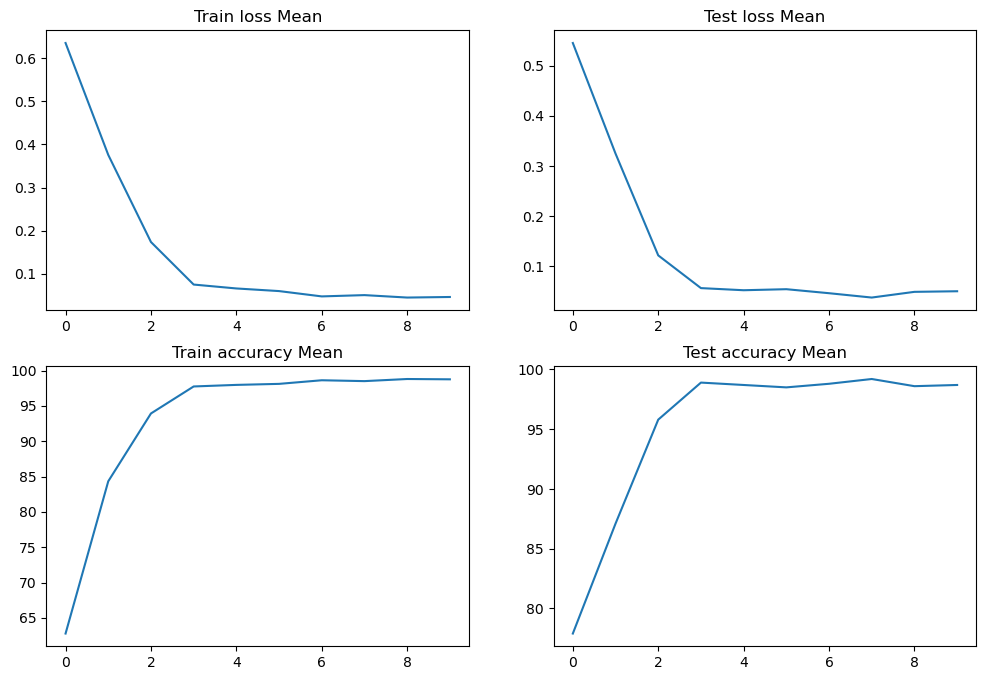

In [10]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 2
figure.add_subplot(rows, cols, 1)
plt.title('Train loss Mean')
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title('Test loss Mean')
plt.plot(all_test_loss_mean)
figure.add_subplot(rows, cols, 3)
plt.title('Train accuracy Mean')
plt.plot(all_train_accuracy)
figure.add_subplot(rows, cols, 4)
plt.title('Test accuracy Mean')
plt.plot(all_test_accuracy)

# Loading Best Model

In [7]:
model = Wide_ResNet(10, 4, 0.3, initial_stride=1, N=8, f=True, r=0, num_classes=2).to(device)
model.load_state_dict(torch.load('equi_resnet.pth'), strict=False)

| Wide-Resnet 10x4
start building 1
layer 1 built
start building 2
layer 2 built
start building 3
layer 3 built
MODEL TOPOLOGY:
	0 - 
	1 - conv1
	2 - conv1._basisexpansion
	3 - conv1._basisexpansion.block_expansion_('irrep_0,0', 'regular')
	4 - layer1
	5 - layer1.0
	6 - layer1.0.bn1
	7 - layer1.0.bn1.batch_norm_[16]
	8 - layer1.0.relu1
	9 - layer1.0.conv1
	10 - layer1.0.conv1._basisexpansion
	11 - layer1.0.conv1._basisexpansion.block_expansion_('regular', 'regular')
	12 - layer1.0.bn2
	13 - layer1.0.bn2.batch_norm_[16]
	14 - layer1.0.relu2
	15 - layer1.0.dropout
	16 - layer1.0.conv2
	17 - layer1.0.conv2._basisexpansion
	18 - layer1.0.shortcut
	19 - layer1.0.shortcut._basisexpansion
	20 - layer1.0.shortcut._basisexpansion.block_expansion_('regular', 'regular')
	21 - layer2
	22 - layer2.0
	23 - layer2.0.bn1
	24 - layer2.0.bn1.batch_norm_[16]
	25 - layer2.0.relu1
	26 - layer2.0.conv1
	27 - layer2.0.conv1._basisexpansion
	28 - layer2.0.bn2
	29 - layer2.0.bn2.batch_norm_[16]
	30 - layer2.0.

_IncompatibleKeys(missing_keys=['conv1.filter', 'layer1.0.conv1.filter', 'layer1.0.conv2.filter', 'layer1.0.shortcut.filter', 'layer2.0.conv1.filter', 'layer2.0.conv2.filter', 'layer2.0.shortcut.filter', 'layer3.0.conv1.filter', 'layer3.0.conv2.filter', 'layer3.0.shortcut.filter'], unexpected_keys=[])

# Testing

In [8]:
true_label, pred_label, pred_score, one_hot = [], [], [], []
with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(tqdm(lense_test)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)

        _, pred = torch.max(_y.data, 1)
        true_label += y.tolist()
        pred_label += pred.tolist()
        pred_score += _y.tolist()
        one_hot += np.eye(3)[y.cpu().numpy()].tolist()

100%|██████████| 63/63 [00:51<00:00,  1.23it/s]


# Confusion Matrix

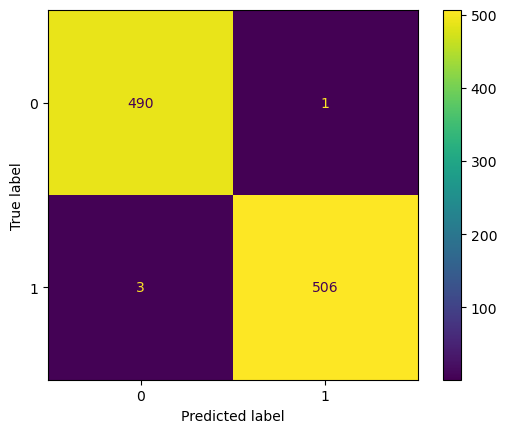

In [9]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(true_label, pred_label)
).plot()

# AUC Score

In [10]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [11]:
roc_auc_score(np.array(true_label),np.array(pred_label))

0.9960347152477401

# ROC-CURVE

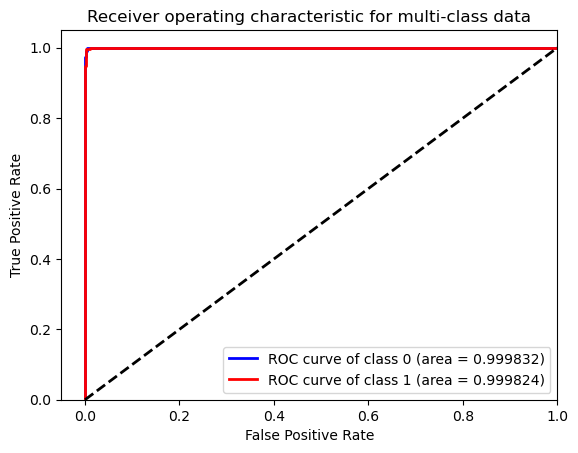

In [12]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(one_hot)[:, i], np.array(pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()